In [1]:
from typing import List, Tuple, Dict, Literal
import os
import re
from pathlib import Path
import pickle
from pprint import pprint

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import yaml

In [2]:
DIR_INPUTS = Path('../../data/inputs')
DIR_PATH_CONFIGS = Path('../../data/configs/paths.yaml')
COLUMNS_BASE = [
    'case_id',
    'date_decision',
    'MONTH',
    'WEEK_NUM',
    'target',
]
COLUMNS_BASE_TEST = [
    'case_id',
    'date_decision',
    'MONTH',
    'WEEK_NUM',
]

In [3]:
dict_tabels_use = {
    0: ['static', 'static_cb'],
    1: [],
    2: [],
}
category_columns_use = ['P', 'M', 'A', 'D']

In [4]:
dir_path = Path.joinpath(DIR_INPUTS, 'csv_files')

with open(DIR_PATH_CONFIGS, 'r') as f:
    dict_tables_all = yaml.safe_load(f)

pprint(dict_tables_all)



{0: {'static': ['static_0_0.csv', 'static_0_1.csv'],
     'static_cb': ['static_cb_0.csv']},
 1: {'applprev': ['applprev_1_0.csv', 'applprev_1_1.csv'],
     'credit_bureau_a': ['credit_bureau_a_1_0.csv',
                         'credit_bureau_a_1_1.csv',
                         'credit_bureau_a_1_2.csv',
                         'credit_bureau_a_1_3.csv'],
     'credit_bureau_b': ['credit_bureau_b_1.csv'],
     'debitcard': ['debitcard_1.csv'],
     'deposit': ['deposit_1.csv'],
     'other': ['other_1.csv'],
     'person': ['person_1.csv'],
     'tax_registry_a': ['tax_registry_a_1.csv'],
     'tax_registry_b': ['tax_registry_b_1.csv'],
     'tax_registry_c': ['tax_registry_c_1.csv']},
 2: {'applprev': ['applprev_2.csv'],
     'credit_bureau_a': ['credit_bureau_a_2_0.csv',
                         'credit_bureau_a_2_1.csv',
                         'credit_bureau_a_2_2.csv',
                         'credit_bureau_a_2_3.csv',
                         'credit_bureau_a_2_4.csv',
     

In [5]:
class DataFrameMerger:
    def __init__(self, dict_tables_all:Dict, dict_tabels_use:Dict, dir_path:Path):
        self.dict_tables_all = dict_tables_all
        self.dict_tabels_use = dict_tabels_use
        self.dir_path = dir_path
        self.df_train = None
        self.df_test = None
        self.df_base = {'train':None, 'test':None}

    def load_concat(self, mode:Literal['train', 'test'])->Tuple[pd.DataFrame, Dict[int, Dict[str, pd.DataFrame]]]:
        dict_df = {0:{}, 1:{}, 2:{}}
        df_base = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_base.csv'))
        self.df_base[mode] = df_base
        print('base', df_base.shape)
        for depth in [0, 1, 2]:
            for k in self.dict_tabels_use[depth]:
                df_ = pd.concat([pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}')) for p in dict_tables_all[0][k]], axis=0)
                print(k, df_.shape)
                dict_df[depth][k] = df_

        return df_base, dict_df
    
    def aggregate(self, dict_df:Dict[int, Dict[str, pd.DataFrame]])->Dict[int, Dict[str, pd.DataFrame]]:
        print('Aggregate by case_id for tables with depth=1, 2')
        print('NOT IMPLEMENTED YET')
        return dict_df
    
    def merge(self, df_base:pd.DataFrame, dict_df:Dict[int, Dict[str, pd.DataFrame]])->pd.DataFrame:
        df = df_base
        for depth in [0, 1, 2]:
            for k in self.dict_tabels_use[depth]:
                df = pd.merge(df, dict_df[depth][k], on='case_id', how='left')
        return df

In [6]:
df_train_merger = DataFrameMerger(dict_tables_all, dict_tabels_use, dir_path)
df_base_train, dict_df_train = df_train_merger.load_concat('train')
dict_df_train = df_train_merger.aggregate(dict_df_train)
df_train = df_train_merger.merge(df_base_train, dict_df_train)

base (1526659, 5)


/var/folders/0z/vv1q7cj15z3gt17m3sp5qcn40000gn/T/ipykernel_36290/1224177632.py:17: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.concat([pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}')) for p in dict_tables_all[0][k]], axis=0)
/var/folders/0z/vv1q7cj15z3gt17m3sp5qcn40000gn/T/ipykernel_36290/1224177632.py:17: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.concat([pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}')) for p in dict_tables_all[0][k]], axis=0)


static (1526659, 168)


/var/folders/0z/vv1q7cj15z3gt17m3sp5qcn40000gn/T/ipykernel_36290/1224177632.py:17: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.concat([pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}')) for p in dict_tables_all[0][k]], axis=0)


static_cb (1500476, 53)
Aggregate by case_id for tables with depth=1, 2
NOT IMPLEMENTED YET


In [7]:
df_train

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.6000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.0000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.0000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.6000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.2000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.36,3675.4001,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,2020-10-19,NaN,NaN,1.0,1.0
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.47,7088.6000,6191.6,0.0,...,NaN,NaN,NaN,NaN,NaN,2020-10-19,NaN,NaN,1.0,2.0
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.40,7788.8003,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,2020-10-19,NaN,NaN,0.0,4.0
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.58,1195.4000,2827.2,0.0,...,NaN,NaN,NaN,NaN,NaN,2020-10-17,NaN,NaN,2.0,1.0


In [21]:
def preprocess(df: pd.DataFrame, category_columns_use:List[str], mode:Literal['train', 'test']='train') -> pd.DataFrame:
    df_ = df.copy()

    columns_base = COLUMNS_BASE.copy()
    if mode == 'test':
        columns_base.remove('target')

    cols_wo_base = [col for col in df_.columns if not col in columns_base]
    cols_use = columns_base.copy()
    for cat in category_columns_use:
        cols_ = [col for col in cols_wo_base if col.endswith(cat)]
        cols_use.extend(cols_)
        if cat == 'P': # numerical features
            pass
        elif cat == 'M': # categorical features
            for col in cols_:
                df_[col] = df_[col].astype('category')
        elif cat == 'A': # numerical features
            pass
        elif cat == 'D': # date features s.t. YYYY-MM-DD
            df_[cols_] = df_[cols_].apply(pd.to_datetime)
            # add new features (year, month, day, weekday)
            for col in cols_:
                df_[f'{col}_year'] = df_[col].dt.year
                df_[f'{col}_month'] = df_[col].dt.month
                df_[f'{col}_day'] = df_[col].dt.day
                df_[f'{col}_weekday'] = df_[col].dt.weekday
                # drop original date columns
                df_ = df_.drop(col, axis=1)
                cols_use.extend([f'{col}_year', f'{col}_month', f'{col}_day', f'{col}_weekday'])
                cols_use.remove(col)
        elif cat == 'T':
            pass
        elif cat == 'L':
            pass

    return df_[cols_use]


In [22]:
df_train_processed = preprocess(df_train, category_columns_use)
y = df_train_processed[COLUMNS_BASE]
X = df_train_processed.drop(columns=COLUMNS_BASE)

/var/folders/0z/vv1q7cj15z3gt17m3sp5qcn40000gn/T/ipykernel_36290/2411636497.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[f'{col}_month'] = df_[col].dt.month
/var/folders/0z/vv1q7cj15z3gt17m3sp5qcn40000gn/T/ipykernel_36290/2411636497.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[f'{col}_day'] = df_[col].dt.day
/var/folders/0z/vv1q7cj15z3gt17m3sp5qcn40000gn/T/ipykernel_36290/2411636497.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

In [23]:
display(X)
display(X.dtypes)
display(y)

,actualdpdtolerance_344P,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avgmaxdpdlast9m_3716943P,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdpdfrom6mto36m_3546853P,...,responsedate_1012D_day,responsedate_1012D_weekday,responsedate_4527233D_year,responsedate_4527233D_month,responsedate_4527233D_day,responsedate_4527233D_weekday,responsedate_4917613D_year,responsedate_4917613D_month,responsedate_4917613D_day,responsedate_4917613D_weekday
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,0.0,-23.0,-43.0,-23.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,10.0,19.0,0.0
1526655,0.0,-18.0,-12.0,-18.0,0.0,0.0,0.0,2.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,10.0,19.0,0.0
1526656,0.0,-12.0,NaN,-16.0,1.0,NaN,NaN,-27.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,10.0,19.0,0.0
1526657,0.0,-33.0,-64.0,-34.0,0.0,0.0,-66.0,0.0,-33.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,10.0,17.0,5.0


actualdpdtolerance_344P          float64
avgdbddpdlast24m_3658932P        float64
avgdbddpdlast3m_4187120P         float64
avgdbdtollast24m_4525197P        float64
avgdpdtolclosure24_3658938P      float64
                                  ...   
responsedate_4527233D_weekday    float64
responsedate_4917613D_year       float64
responsedate_4917613D_month      float64
responsedate_4917613D_day        float64
responsedate_4917613D_weekday    float64
Length: 166, dtype: object

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1
...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0
1526655,2703451,2020-10-05,202010,91,0
1526656,2703452,2020-10-05,202010,91,0
1526657,2703453,2020-10-05,202010,91,0


In [25]:
X_tv, X_oof, y_tv, y_oof = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y['target']
)

In [26]:
params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 0.0001,
    'lambda_l2': 0.0001,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 50,
    'seed': 42,
}

In [28]:
print(X_tv.shape, y_tv.shape, X_oof.shape, y_oof.shape)

(1221327, 166) (1221327, 5) (305332, 166) (305332, 5)


In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
for n, (train_index, valid_index) in enumerate(skf.split(X_tv, y_tv['target'])):
    print(f'Fold {n+1}')
    dataset_train = lgb.Dataset(X_tv.iloc[train_index], y_tv.iloc[train_index]['target'])
    dataset_valid = lgb.Dataset(X_tv.iloc[valid_index], y_tv.iloc[valid_index]['target'])

    model = lgb.train(
        params,
        dataset_train,
        num_boost_round=100_000,
        valid_sets=[dataset_train, dataset_valid],
        callbacks=[
            lgb.early_stopping(100, first_metric_only=True),
            lgb.log_evaluation(100),
        ],
    )
    models.append(model)

Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.11455	training's auc: 0.83042	valid_1's binary_logloss: 0.121254	valid_1's auc: 0.792038
[200]	training's binary_logloss: 0.109468	training's auc: 0.852969	valid_1's binary_logloss: 0.121003	valid_1's auc: 0.793684
[300]	training's binary_logloss: 0.105583	training's auc: 0.867977	valid_1's binary_logloss: 0.120949	valid_1's auc: 0.794009
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.105753	training's auc: 0.867353	valid_1's binary_logloss: 0.120935	valid_1's auc: 0.794161
Evaluated only: binary_logloss
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.114421	training's auc: 0.83093	valid_1's binary_logloss: 0.121775	valid_1's auc: 0.787347
[200]	training's binary_logloss: 0.109432	training's auc: 0.852386	valid_1's binary_logloss: 0.121488	valid_1's auc: 0.788974
[300]	training's binary_logloss: 0.105678	t

In [30]:
# save models
save_dir = Path('../../data/models/static-PMAD-lgbm-cv')
if not save_dir.exists():
    save_dir.mkdir(parents=True)
    print(f'Create {save_dir}')
for i, model in enumerate(models):
    with open(Path.joinpath(save_dir, f'model_{i}.pkl'), 'wb') as f:
        pickle.dump(model, f)

Create ../../data/models/static-PMAD-lgbm-cv


## evaluation (out of fold)

In [31]:
def get_y_pred_folds(models:List[lgb.basic.Booster], X:pd.DataFrame)->np.ndarray:
    y_pred_folds = []
    for model in models:
        y_pred = model.predict(X)
        y_pred_folds.append(y_pred)
    return np.array(y_pred_folds)

In [32]:
models = []
for i in range(5):
    with open(Path.joinpath(save_dir, f'model_{i}.pkl'), 'rb') as f:
        model = pickle.load(f)
        models.append(model)

In [33]:
y_pred_oof_folds = get_y_pred_folds(models, X_oof)
y_pred_oof = np.mean(y_pred_oof_folds, axis=0)

0.7926155684490965


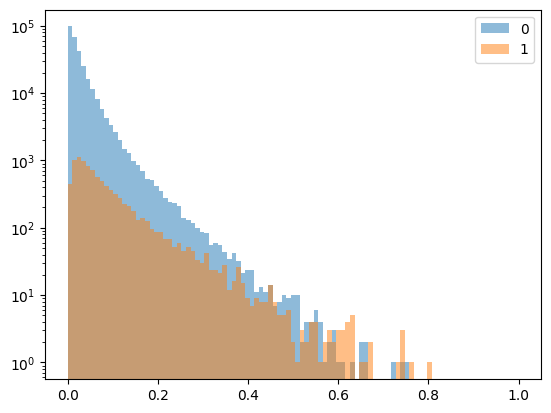

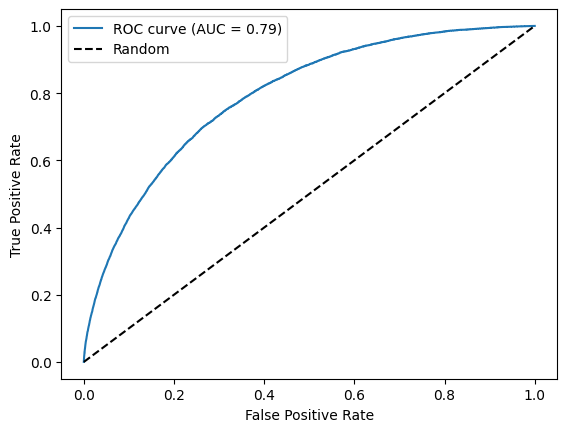

0.5531838442745762


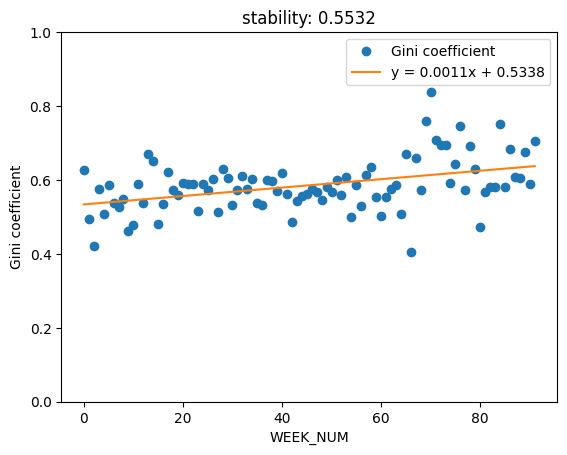

(    WEEK_NUM      Gini
0          0  0.627538
1          1  0.494640
2          2  0.420193
3          3  0.574263
4          4  0.507267
..       ...       ...
87        87  0.607015
88        88  0.604752
89        89  0.676605
90        90  0.590216
91        91  0.704850

[92 rows x 2 columns], 0.5531838442745762)


In [34]:
print(roc_auc_score(y_oof['target'], y_pred_oof))

def plot_pred(y_truth:pd.DataFrame, y_pred:np.ndarray, is_log:bool=False)->None:
    fig, ax = plt.subplots()
    bins = np.linspace(0, 1, 100)
    ax.hist(y_pred[y_truth['target'] == 0], bins=bins, alpha=0.5, label='0')
    ax.hist(y_pred[y_truth['target'] == 1], bins=bins, alpha=0.5, label='1')
    ax.legend()
    if is_log:
        ax.set_yscale('log')
    plt.show()

def plot_roc(y_truth:pd.DataFrame, y_pred:np.ndarray)->None:
    fpr, tpr, thresholds = roc_curve(y_truth['target'], y_pred)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f'ROC curve (AUC = {auc(fpr, tpr):.2f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    plt.show()

def plot_gini(y_truth:pd.DataFrame, y_pred:np.ndarray)->Tuple[pd.DataFrame, float]:
    gini_weeks = []

    for week in range(0, 92):
        idx_week = (y_truth['WEEK_NUM'] == week)
        y_pred_week = y_pred[idx_week]
        y_test_week = y_truth[idx_week]
        gini_week = 2 * roc_auc_score(y_test_week['target'], y_pred_week) - 1
        gini_weeks.append(gini_week)

    gini_weeks = np.array(gini_weeks)
    linear_regression = LinearRegression()
    linear_regression.fit(np.arange(0, 92).reshape(-1, 1), gini_weeks)
    a, b = linear_regression.coef_[0], linear_regression.intercept_

    residuals = gini_weeks - linear_regression.predict(np.arange(0, 92).reshape(-1, 1))
    stability = gini_weeks.mean() + 88.0 * np.amin([0, a]) - 0.5 * residuals.std()
    print(stability)

    fig, ax = plt.subplots()
    ax.plot(gini_weeks, marker='o', linestyle='', label='Gini coefficient')
    ax.plot(
        linear_regression.predict(np.arange(0, 92).reshape(-1, 1)),
        label=f'y = {a:.4f}x + {b:.4f}'
    )
    ax.set(
        xlabel='WEEK_NUM',
        ylabel='Gini coefficient',
        ylim=[0, 1],
        title='stability: {:.4f}'.format(stability)
    )
    ax.legend()
    plt.show()

    df_gini_weeks = pd.DataFrame({
        'WEEK_NUM': np.arange(0, 92),
        'Gini': gini_weeks,
    })
    return df_gini_weeks, stability

plot_pred(y_oof, y_pred_oof, is_log=True)
plot_roc(y_oof, y_pred_oof)
print(plot_gini(y_oof, y_pred_oof))

## evaluation (test dataset) and submission

In [39]:
df_base_test, dict_df_test = df_train_merger.load_concat('test')
dict_df_test = df_train_merger.aggregate(dict_df_test)
df_test = df_train_merger.merge(df_base_test, dict_df_test)

df_test_processed = preprocess(df_test, category_columns_use, mode='test')
X_test = df_test_processed.drop(columns=COLUMNS_BASE_TEST)

base (10, 4)
static (20, 168)
static_cb (10, 53)
Aggregate by case_id for tables with depth=1, 2
NOT IMPLEMENTED YET


In [42]:
y_pred_test_folds = get_y_pred_folds(models, X_test)
y_pred_test = np.mean(y_pred_test_folds, axis=0)

df_submission = pd.DataFrame({
    'case_id': df_test['case_id'],
    'score': y_pred_test,
})

df_submission.to_csv('../../data/outputs/submission.csv', index=False)

In [43]:
df_submission

,case_id,score
0,57543,0.053082
1,57549,0.063964
2,57551,0.045013
3,57552,0.029106
4,57569,0.007297
5,57630,0.022945
6,57631,0.006501
7,57632,0.004456
8,57633,0.049782
9,57634,0.052734
